In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv") 
# data=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv") #train

# test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv") #test


print(train_data.shape)
train_data.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print(test_data.shape)
# test_data.head()
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv') #submission

(3263, 4)


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_data.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

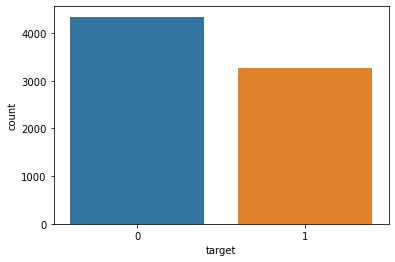

In [7]:
sns.countplot(x="target", data=train_data)

In [8]:
def clean_text(text):
    
    sw = stopwords.words('english')
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [9]:
mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

In [10]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [11]:
train_data['text'] = train_data['text'].str.lower()
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
train_data['text'] = train_data['text'].apply(lambda x: replace_misspell(x))

 
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,", people receive wildfires evacuation orders c...",1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [12]:
test_data['text'] = test_data['text'].str.lower()
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: replace_misspell(x))


test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard earthquake different cities, stay safe e..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [13]:
x_train,x_test,y_train,y_test=train_test_split(train_data['text'].values,train_data['target'].values,test_size=0.2,random_state=123)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=123)

In [14]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index) + 1

In [15]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,padding='post')

validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences,padding='post')

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,padding='post')

In [16]:
#Actual test data- test_data
test1_sequences = tokenizer.texts_to_sequences(test_data.text)
test1_padded = pad_sequences(test1_sequences, maxlen=20, padding='post', truncating='post')

In [17]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words, 100),
#tf.keras.layers.LSTM(64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,recurrent_dropout=0.1)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1765200   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,032,721
Trainable params: 2,032,721
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 20

In [20]:
history = model.fit(train_padded, y_train, epochs=num_epochs,validation_data=(validation_padded, y_val), verbose=2)

Epoch 1/20
172/172 - 15s - loss: 0.6650 - accuracy: 0.5864 - val_loss: 0.6270 - val_accuracy: 0.6568
Epoch 2/20
172/172 - 14s - loss: 0.5535 - accuracy: 0.7435 - val_loss: 0.4872 - val_accuracy: 0.7865
Epoch 3/20
172/172 - 15s - loss: 0.3113 - accuracy: 0.8779 - val_loss: 0.4771 - val_accuracy: 0.7882
Epoch 4/20
172/172 - 14s - loss: 0.1862 - accuracy: 0.9336 - val_loss: 0.5309 - val_accuracy: 0.7734
Epoch 5/20
172/172 - 14s - loss: 0.1095 - accuracy: 0.9591 - val_loss: 0.5876 - val_accuracy: 0.7570
Epoch 6/20
172/172 - 14s - loss: 0.0600 - accuracy: 0.9810 - val_loss: 0.7330 - val_accuracy: 0.7291
Epoch 7/20
172/172 - 15s - loss: 0.0434 - accuracy: 0.9838 - val_loss: 0.8650 - val_accuracy: 0.6962
Epoch 8/20
172/172 - 14s - loss: 0.0282 - accuracy: 0.9900 - val_loss: 0.8389 - val_accuracy: 0.7471
Epoch 9/20
172/172 - 14s - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.8328 - val_accuracy: 0.7406
Epoch 10/20
172/172 - 14s - loss: 0.0197 - accuracy: 0.9945 - val_loss: 0.8644 - val_accura

In [21]:
y_pred = model.predict_classes(test_padded)

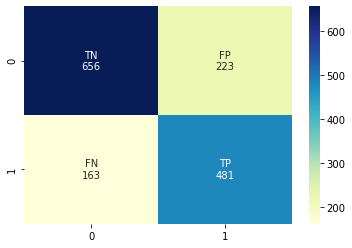

In [22]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='YlGnBu');

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       879
           1       0.68      0.75      0.71       644

    accuracy                           0.75      1523
   macro avg       0.74      0.75      0.74      1523
weighted avg       0.75      0.75      0.75      1523



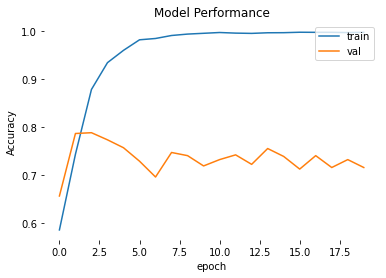

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.box(False)
plt.show()

In [25]:
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [26]:
words_na = []
embedding_matrix = np.zeros((num_words,100))
word_index = tokenizer.word_index
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    
    if emb_vec is None:
        
        
        words_na.append(word)
    
    elif emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 17651/17651 [00:00<00:00, 232843.20it/s]


In [27]:
print("Out of vocabulory words:",len(words_na))

Out of vocabulory words: 6572


In [28]:
model2 = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),trainable=False),
#tf.keras.layers.LSTM(64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
tf.keras.layers.Dense(128, activation='relu'),
# tf.keras.layers.Dense(256, activation = 'relu'),    
tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1765200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,032,721
Trainable params: 267,521
Non-trainable params: 1,765,200
_________________________________________________________________


In [30]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,restore_best_weights=True, mode='auto')
history = model2.fit(train_padded, y_train, epochs=num_epochs,validation_data=(validation_padded, y_val), verbose=2,callbacks=[earlystop])

Epoch 1/20
172/172 - 6s - loss: 0.5607 - accuracy: 0.7367 - val_loss: 0.5130 - val_accuracy: 0.7635
Epoch 2/20
172/172 - 5s - loss: 0.4379 - accuracy: 0.8050 - val_loss: 0.4700 - val_accuracy: 0.7898
Epoch 3/20
172/172 - 5s - loss: 0.4186 - accuracy: 0.8188 - val_loss: 0.4848 - val_accuracy: 0.7865
Epoch 4/20
172/172 - 5s - loss: 0.4119 - accuracy: 0.8217 - val_loss: 0.4565 - val_accuracy: 0.7882
Epoch 5/20
172/172 - 5s - loss: 0.4028 - accuracy: 0.8245 - val_loss: 0.4498 - val_accuracy: 0.7947
Epoch 6/20
172/172 - 5s - loss: 0.3961 - accuracy: 0.8221 - val_loss: 0.4516 - val_accuracy: 0.7915
Epoch 7/20
172/172 - 5s - loss: 0.3873 - accuracy: 0.8318 - val_loss: 0.4500 - val_accuracy: 0.7997
Epoch 8/20
172/172 - 5s - loss: 0.3823 - accuracy: 0.8351 - val_loss: 0.4477 - val_accuracy: 0.7997
Epoch 9/20
172/172 - 5s - loss: 0.3762 - accuracy: 0.8393 - val_loss: 0.4435 - val_accuracy: 0.7947
Epoch 10/20
172/172 - 5s - loss: 0.3689 - accuracy: 0.8451 - val_loss: 0.4412 - val_accuracy: 0.8013

In [31]:
y_pred = model2.predict_classes(test_padded)

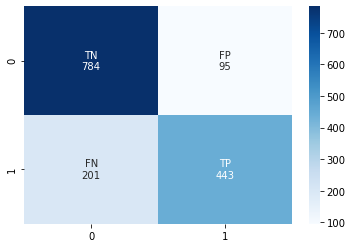

In [32]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       879
           1       0.82      0.69      0.75       644

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



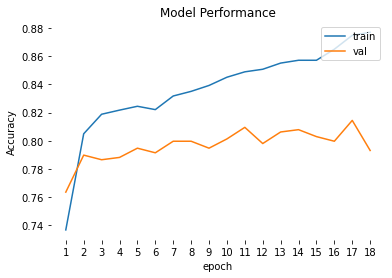

In [34]:
epochs = range(1,len(history.history['loss'])+1)
plt.plot(epochs,history.history['accuracy'])
plt.plot(epochs,history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.xticks(epochs)
plt.legend(['train', 'val'], loc='upper right')
plt.box(False)
plt.show()

In [35]:
# y_pred = model2.predict_classes(y_pred)



In [36]:
test_pred = model2.predict(test1_padded)
sub['target'] = (test_pred > 0.5).astype(int)
sub.to_csv("submission.csv", index=False, header=True)

In [37]:
# sub["target"].shape

In [38]:
# sub["target"] = df

In [39]:
# print(sub.head())

In [40]:
# sub.to_csv("submission.csv", index=False)

In [41]:
# from IPython.display import FileLink
# FileLink(r'submission.csv')

In [42]:
# print(sub)